In [14]:
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras

In [15]:
data_dir = 'manual'
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    zoom_range=0.2,
    width_shift_range=10,
    height_shift_range=10,
)
flow_params = {
    'class_mode': 'sparse',
    'color_mode': 'grayscale',
    'target_size': (128, 128),
#     'batch_size': batch_size,
}
test_it = datagen.flow_from_directory(data_dir, **flow_params)

Found 396 images belonging to 6 classes.


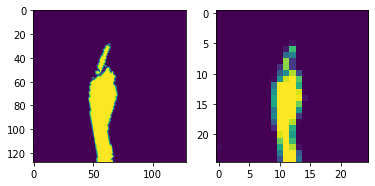

In [16]:
Xtrain, _ = test_it.next()
_, (ax1, ax2) = plt.subplots(1, 2)
X = Xtrain[0]
ax1.imshow(X)
ax2.imshow(keras.layers.AveragePooling2D(5)(Xtrain)[0])
plt.show()

In [17]:
model = keras.Sequential([
    keras.layers.Conv2D(64, 3, input_shape=(128, 128, 1), activation='relu'),
    keras.layers.MaxPooling2D(3),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPooling2D(3),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(6, activation='softmax'),
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2769152   
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 13 steps, validate for 13 steps
Epoch 1/50
13/13 [==============================] - 14s 1s/step - loss: 19.6159 - accuracy: 0.1793 - val_loss: 1.9685 - val_accuracy: 0.1869
Epoch 2/50
13/13 [==============================] - 13s 1s/step - loss: 1.8598 - accuracy: 0.1970 - val_loss: 1.7947 - val_accuracy: 0.1843
Epoch 3/50
13/13 [==============================] - 14s 1s/step - loss: 1.7668 - accuracy: 0.2298 - val_loss: 1.7690 - val_accuracy: 0.2273
Epoch 4/50
13/13 [==============================] - 13s 1s/step - loss: 1.7730 - accuracy: 0.2096 - val_loss: 1.7431 - val_accuracy: 0.2677
Epoch 5/50
13/13 [==============================] - 14s 1s/step - loss: 1.7523 - accuracy: 0.2576 - val_loss: 1.7240 - val_accuracy: 0.2828
Epoch 6/50
13/13 [==============================] - 13s 1s/step - loss: 1.6951 - accuracy: 0.2854 - val_loss: 1.6443 - val_accuracy: 0.3409
Epoch 7/50
13/13 [==============================] - 14s 1s/step - l

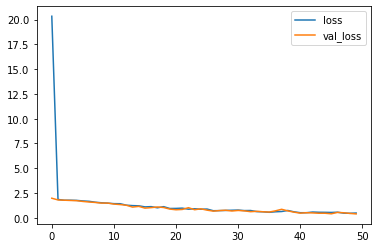

In [18]:
history = model.fit(test_it, validation_data=test_it, epochs=50)
df = pd.DataFrame(history.history)
df[['loss', 'val_loss']].plot()
plt.show()

In [19]:
model.save('manualmodel85')

INFO:tensorflow:Assets written to: manualmodel85/assets


In [ ]:
import keract
activations = keract.get_activations(model, test_it, auto_compile=True)
keract.display_activations(activations, cmap=None, save=False, directory='.', data_format='channels_last', fig_size=(24, 24), reshape_1d_layers=False)